In [1]:
import numpy as np 
import pandas as pd 
import os

import keras
import tensorflow as tf
import tensorflow
import keras
import sklearn
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from platform import  python_version
from glob import glob
from keras import backend as K
from tqdm import tqdm
from PIL import Image

!pip install patchify
from patchify import patchify
# from PIL import Image
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam

import shutil

!pip install segmentation-models
import segmentation_models as sm
import warnings
warnings.filterwarnings("ignore")

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

%config Completer.use_jedi = False

sm.set_framework('tf.keras')
sm.framework()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 3.2 MB/s eta 0:00:00
Segmentation Models: using `keras` framework.


'tf.keras'

In [2]:
base_dir = '/kaggle/input/deepglobe-land-cover-classification-dataset'
print(os.listdir(base_dir))
print("Keras version : " + keras.__version__)
print("Tensorflow version : " + tf.__version__)
print("Python version : " + python_version())
print("Sklearn version : " + sklearn.__version__)
print("CV2 version : " + cv2.__version__)
print("Pandas version : " + pd.__version__)


['class_dict.csv', 'valid', 'metadata.csv', 'test', 'train']
Keras version : 2.6.0
Tensorflow version : 2.6.3
Python version : 3.7.12
Sklearn version : 1.0.2
CV2 version : 4.5.4
Pandas version : 1.3.5


In [3]:
filenames = pd.read_csv(os.path.join(base_dir, 'metadata.csv'))
filenames

image_id  split        sat_image_path              mask_path
0       100694  train  train/100694_sat.jpg  train/100694_mask.png
1       102122  train  train/102122_sat.jpg  train/102122_mask.png
2        10233  train   train/10233_sat.jpg   train/10233_mask.png
3       103665  train  train/103665_sat.jpg  train/103665_mask.png
4       103730  train  train/103730_sat.jpg  train/103730_mask.png
...        ...    ...                   ...                    ...
1141    979233   test   test/979233_sat.jpg                    NaN
1142    983689   test   test/983689_sat.jpg                    NaN
1143    988205   test   test/988205_sat.jpg                    NaN
1144    989953   test   test/989953_sat.jpg                    NaN
1145    999380   test   test/999380_sat.jpg                    NaN

[1146 rows x 4 columns]

In [4]:
print(filenames['split'].value_counts())

train    803
test     172
valid    171
Name: split, dtype: int64


In [5]:
train_df = filenames[filenames['split']=='train']
train_df['sat_image_path'] = train_df['sat_image_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
train_df['mask_path'] = train_df['mask_path'].apply(lambda img_pth: os.path.join(base_dir, img_pth))
train_df

image_id  split                                     sat_image_path  \
0      100694  train  /kaggle/input/deepglobe-land-cover-classificat...   
1      102122  train  /kaggle/input/deepglobe-land-cover-classificat...   
2       10233  train  /kaggle/input/deepglobe-land-cover-classificat...   
3      103665  train  /kaggle/input/deepglobe-land-cover-classificat...   
4      103730  train  /kaggle/input/deepglobe-land-cover-classificat...   
..        ...    ...                                                ...   
798    992507  train  /kaggle/input/deepglobe-land-cover-classificat...   
799    994520  train  /kaggle/input/deepglobe-land-cover-classificat...   
800    995492  train  /kaggle/input/deepglobe-land-cover-classificat...   
801    997521  train  /kaggle/input/deepglobe-land-cover-classificat...   
802    998002  train  /kaggle/input/deepglobe-land-cover-classificat...   

                                             mask_path  
0    /kaggle/input/deepglobe-land-cover-classificat...  
1    /kaggle/input/deepglobe-land-cover-classificat...  
2    /kaggle/input/deepglobe-land-cover-classificat...  
3    /kaggle/input/deepglobe-land-cover-classificat...  
4    /kaggle/input/deepglobe-land-cover-classificat...  
..                                                 ...  
798  /kaggle/input/deepglobe-land-cover-classificat...  
799  /kaggle/input/deepglobe-land-cover-classificat...  
800  /kaggle/input/deepglobe-land-cover-classificat...  
801  /kaggle/input/deepglobe-land-cover-classificat...  
802  /kaggle/input/deepglobe-land-cover-classificat...  

[803 rows x 4 columns]

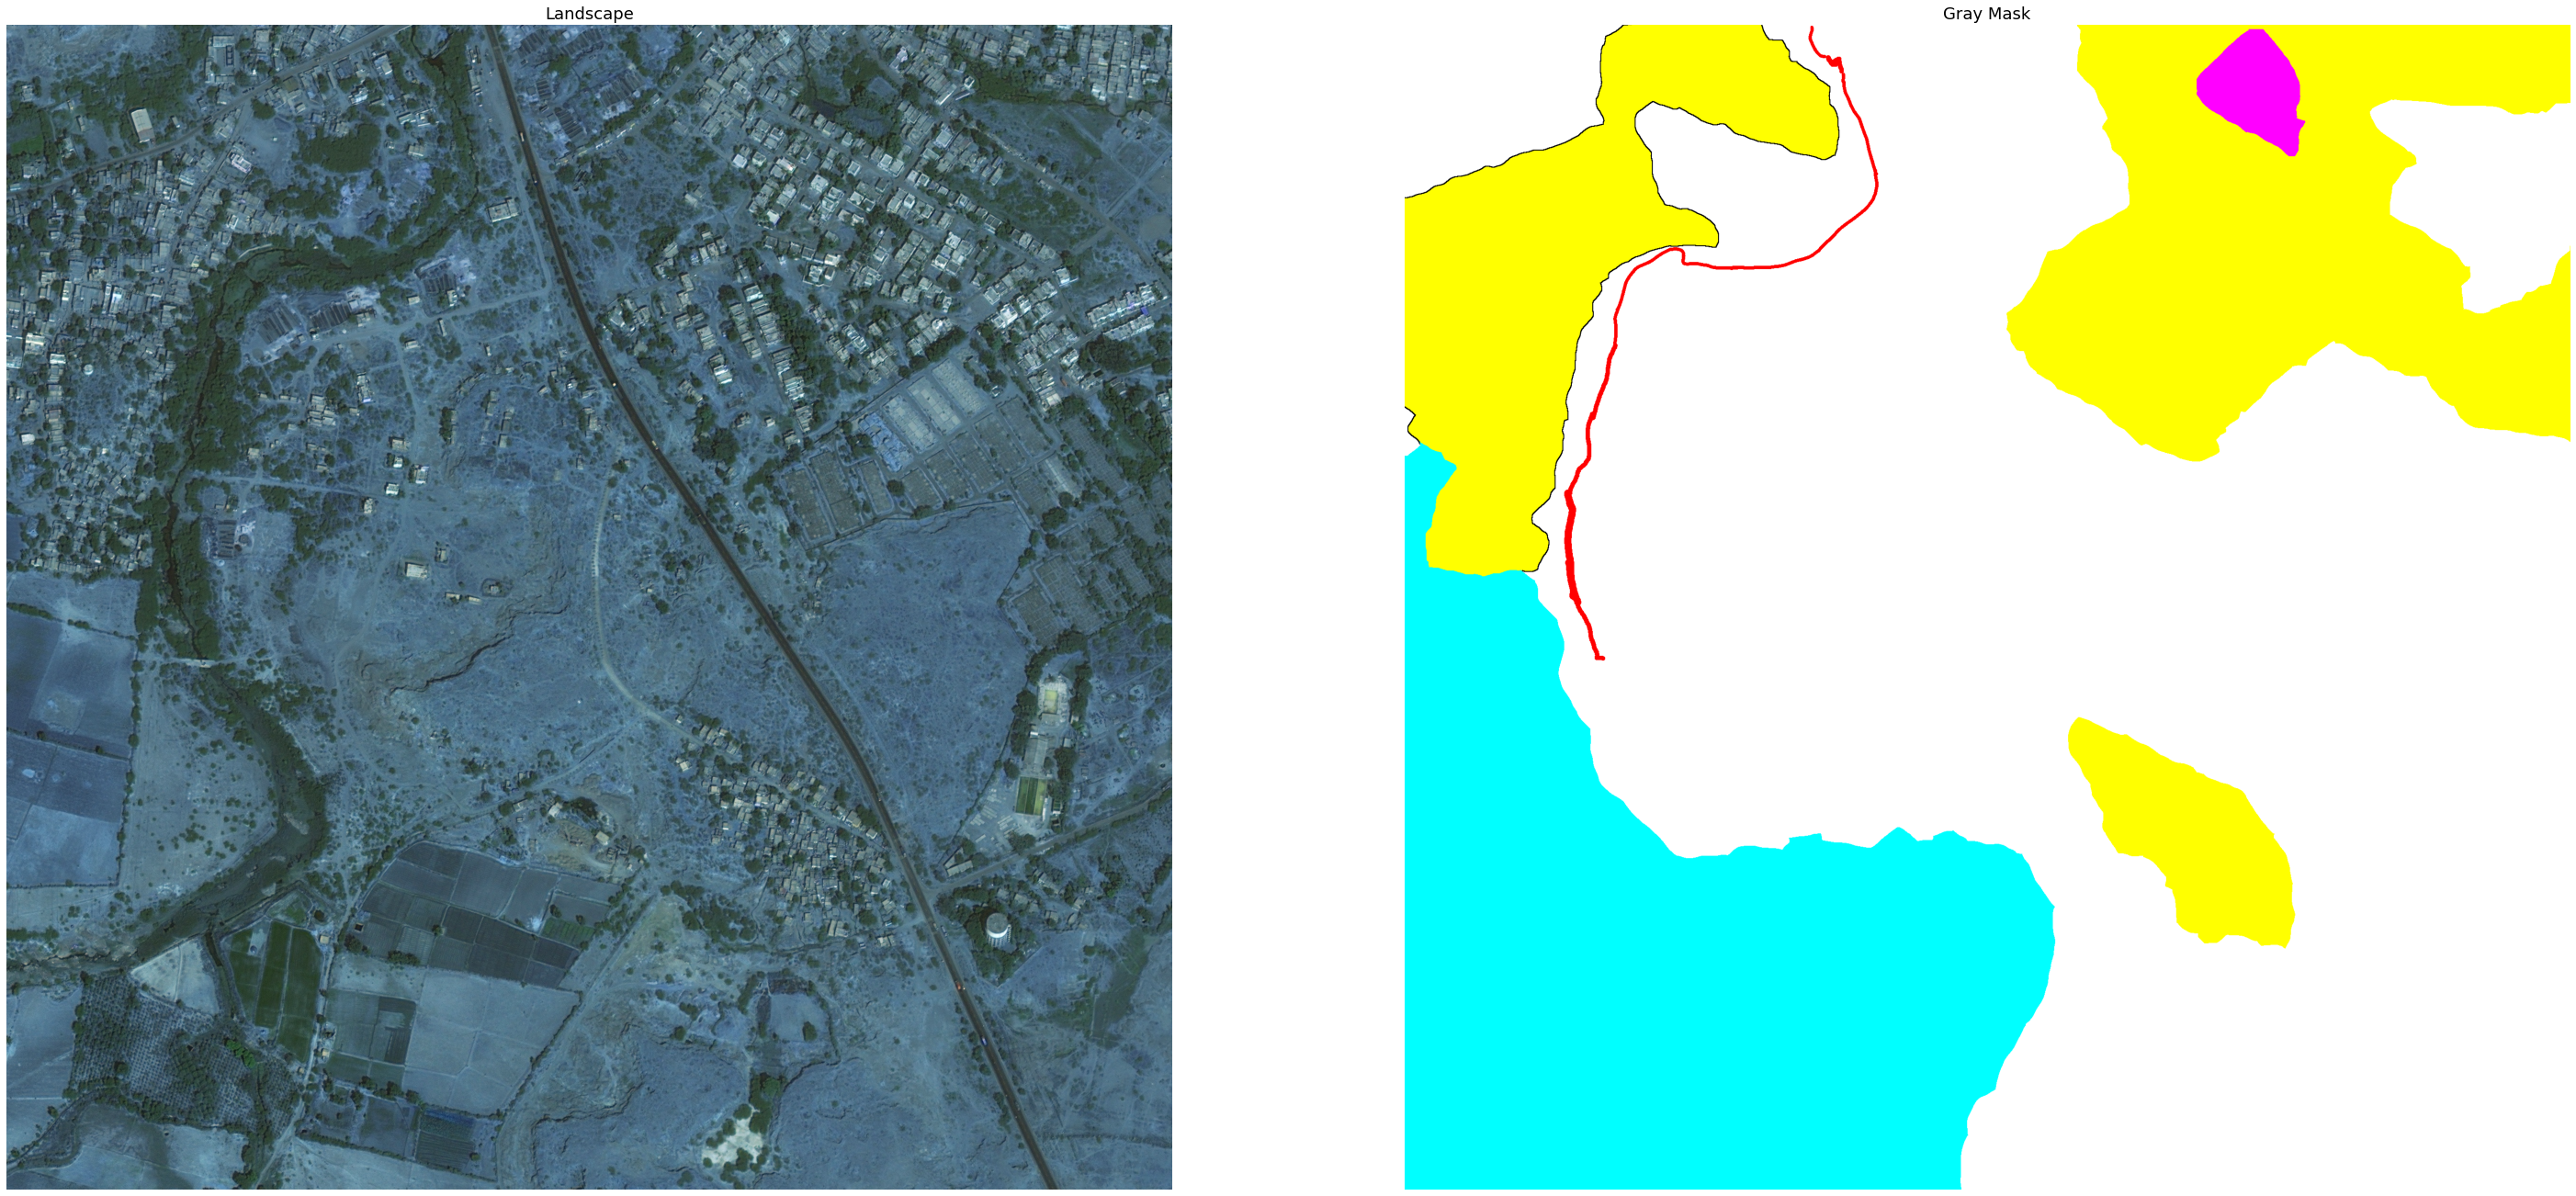

In [6]:
i = np.random.randint(0, len(train_df))
img = cv2.imread(train_df['sat_image_path'].iloc[i])
mask = cv2.imread(train_df['mask_path'].iloc[i])
plt.figure(figsize=(50,50))

plt.subplot(121)
plt.axis('off')
plt.title('Landscape',fontsize=18)
plt.imshow(img)

plt.subplot(122)
plt.axis('off')
plt.title('Gray Mask',fontsize=18 )
plt.imshow(mask)


In [7]:
class_dict = pd.read_csv(os.path.join(base_dir, 'class_dict.csv'))
num_class = len(class_dict)
print(f'Number of classes {num_class}')
class_dict

Number of classes 7


name    r    g    b
0        urban_land    0  255  255
1  agriculture_land  255  255    0
2         rangeland  255    0  255
3       forest_land    0  255    0
4             water    0    0  255
5       barren_land  255  255  255
6           unknown    0    0    0

In [8]:
if os.path.exists('masks256') :
    shutil.rmtree('masks256')
if os.path.exists('images256') :    
    shutil.rmtree('images256')
    
os.mkdir('images256')
os.mkdir('masks256')
patch_size =256


def patches(train_df):
    num_of_saved_files = 0
    for img_path, mask_path in tqdm(train_df[['sat_image_path','mask_path']].to_numpy()):
        image = cv2.imread(img_path, 1)
        mask = cv2.imread(mask_path)
        assert image.shape == mask.shape
        SIZE_X = (image.shape[1]//patch_size)*patch_size 
        SIZE_Y = (image.shape[0]//patch_size)*patch_size
        
        image = Image.fromarray(image)
        image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
        image = np.array(image)             

        patches_img = patchify(image, (256, 256, 3), step=256)  #Step=256 for 256 patches means no overlap
        patches_mask = patchify(mask, (256, 256, 3), step=256) 
        
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = single_patch_mask[0]
                
                val, counts = np.unique(single_patch_mask, return_counts=True)
                max_counts = np.max(counts)/counts.sum()
                if max_counts < 0.95:
                    single_patch_img = patches_img[i,j,:,:]
                    single_patch_img = single_patch_img[0]

                    cv2.imwrite(f'images256/{num_of_saved_files}.tif', single_patch_img)
                    cv2.imwrite(f'masks256/{num_of_saved_files}.tif', single_patch_mask) 
                    num_of_saved_files += 1

In [9]:
# Run for creating patches 256x256
# patches(train_df)

In [10]:

colors = []
for (r,g,b) in class_dict[['r', 'g', 'b']].to_numpy():
    colors.append([r,g,b])
map_color = {x:v for x,v in zip(range(num_class),colors)}
colors

map_color

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [11]:
{1:[255, 255,0]}

{1: [255, 255, 0]}

### Preproccesing

In [12]:
# https://stackoverflow.com/questions/43884463/how-to-convert-rgb-image-to-one-hot-encoded-3d-array-based-on-color-using-numpy
# Author : MonsterMax
num_classes =7
def rgb_to_onehot(rgb_arr):
    color_dict= map_color
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2]+(num_classes,)
    arr = np.zeros( shape, dtype=np.int8 )
    for i, cls_ in enumerate(color_dict):
        arr[:,:,i] = np.all(rgb_arr.reshape( (-1,3) ) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def preprocess_data_rgb_to_onehot(img, mask, num_class=7):
    masks = np.zeros((mask.shape[0], 256, 256,7))
    for i ,m in enumerate(mask):
        masks[i] =rgb_to_onehot(m)      
        img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    return (img,masks)

In [14]:
def onehot_to_rgb(onehot, color_dict= map_color):
    single_layer = np.argmax(onehot, axis=-1)
    output = np.zeros( onehot.shape[:2]+(3,) )
    for k in color_dict.keys():
        output[single_layer==k] = color_dict[k]
    return np.uint8(output)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 32
patched_dir = '../input/patched/data'

def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args )
    
    validation_split= 0.1

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    

    mask_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False)
   

    image_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None,
        validate_filenames=False) 
     
    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)
   
def transform_generator(gen):
    for (img, mask) in gen:
        before = (img.shape,mask.shape)
        img, mask = preprocess_data_rgb_to_onehot(img, mask)
        yield (img, mask)
        
def train_valid_gen(num_class=7):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)

In [16]:
t, v = train_valid_gen()

Found 2692 validated image filenames.
Found 2692 validated image filenames.
Found 300 non-validated image filenames.
Found 300 non-validated image filenames.


In [17]:
%%time
x, y=next(t)

CPU times: user 11.9 s, sys: 52.4 ms, total: 11.9 s
Wall time: 12.4 s


Preprocess_data takes Wall time: 8.82s for batch size = 32

In [18]:
def one_hot_encode(label):
    label_values = colors
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1).astype('float')

    return semantic_map

In [19]:
def preprocess_data(imgs, masks):
    return (imgs,one_hot_encode(masks))

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed=24
batch_size= 32

patched_dir = '../input/patched/data'

def data_generator(num_class=7):
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args, rescale=1.0/255.0)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)


    validation_split= 0.2

    df_len = len(glob(os.path.join(patched_dir,'images256/*.tif')))
    subset = np.empty(df_len, dtype=object)
    subset[:int((1-validation_split)*df_len)] = 'train'
    subset[int((1-validation_split)*df_len):] = 'valid'
    np.random.shuffle(subset)
    df_filenames = pd.DataFrame(np.vstack((np.sort(np.array((glob(os.path.join(patched_dir,'images256/*.tif')),glob(os.path.join(patched_dir,'masks256/*.tif'))))), subset)).T, columns = ['img', 'masks','subset'])
    df_train = df_filenames[df_filenames.subset  == 'train']
    df_valid = df_filenames[df_filenames.subset  == 'valid']

    image_train_generator = image_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    
    mask_train_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_train,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
    

    mask_valid_generator = mask_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="masks",
        batch_size= batch_size,
        seed=24,
        class_mode = None)
   

    image_valid_generator = image_datagen.flow_from_dataframe(
        dataframe = df_valid,
        train_dir=None,
        x_col="img",
        batch_size= batch_size,
        seed=24,
        class_mode = None) 
     
    train_generator= zip(image_train_generator,mask_train_generator)
    valid_generator = zip(image_valid_generator, mask_valid_generator)
    return(train_generator,valid_generator)
   
def transform_generator(gen):
    for (img, mask) in gen:
        img, mask = preprocess_data(img, mask)
        yield (img, mask)
        
def train_valid_gen(num_class=7):
    train_gen,valid_gen = data_generator(num_class=num_class)
    train_gen = transform_generator(train_gen)
    valid_gen = transform_generator(valid_gen)
    return (train_gen,valid_gen)

In [21]:
t, v = train_valid_gen()

Found 2393 validated image filenames.
Found 2393 validated image filenames.
Found 599 validated image filenames.
Found 599 validated image filenames.


In [22]:
%%time
x, y=next(t)

CPU times: user 743 ms, sys: 51.7 ms, total: 795 ms
Wall time: 1.21 s


one_hot_encode reduces Wall time to 1.11 s

### Check generator

In [23]:
t, v = train_valid_gen()

Found 2393 validated image filenames.
Found 2393 validated image filenames.
Found 599 validated image filenames.
Found 599 validated image filenames.


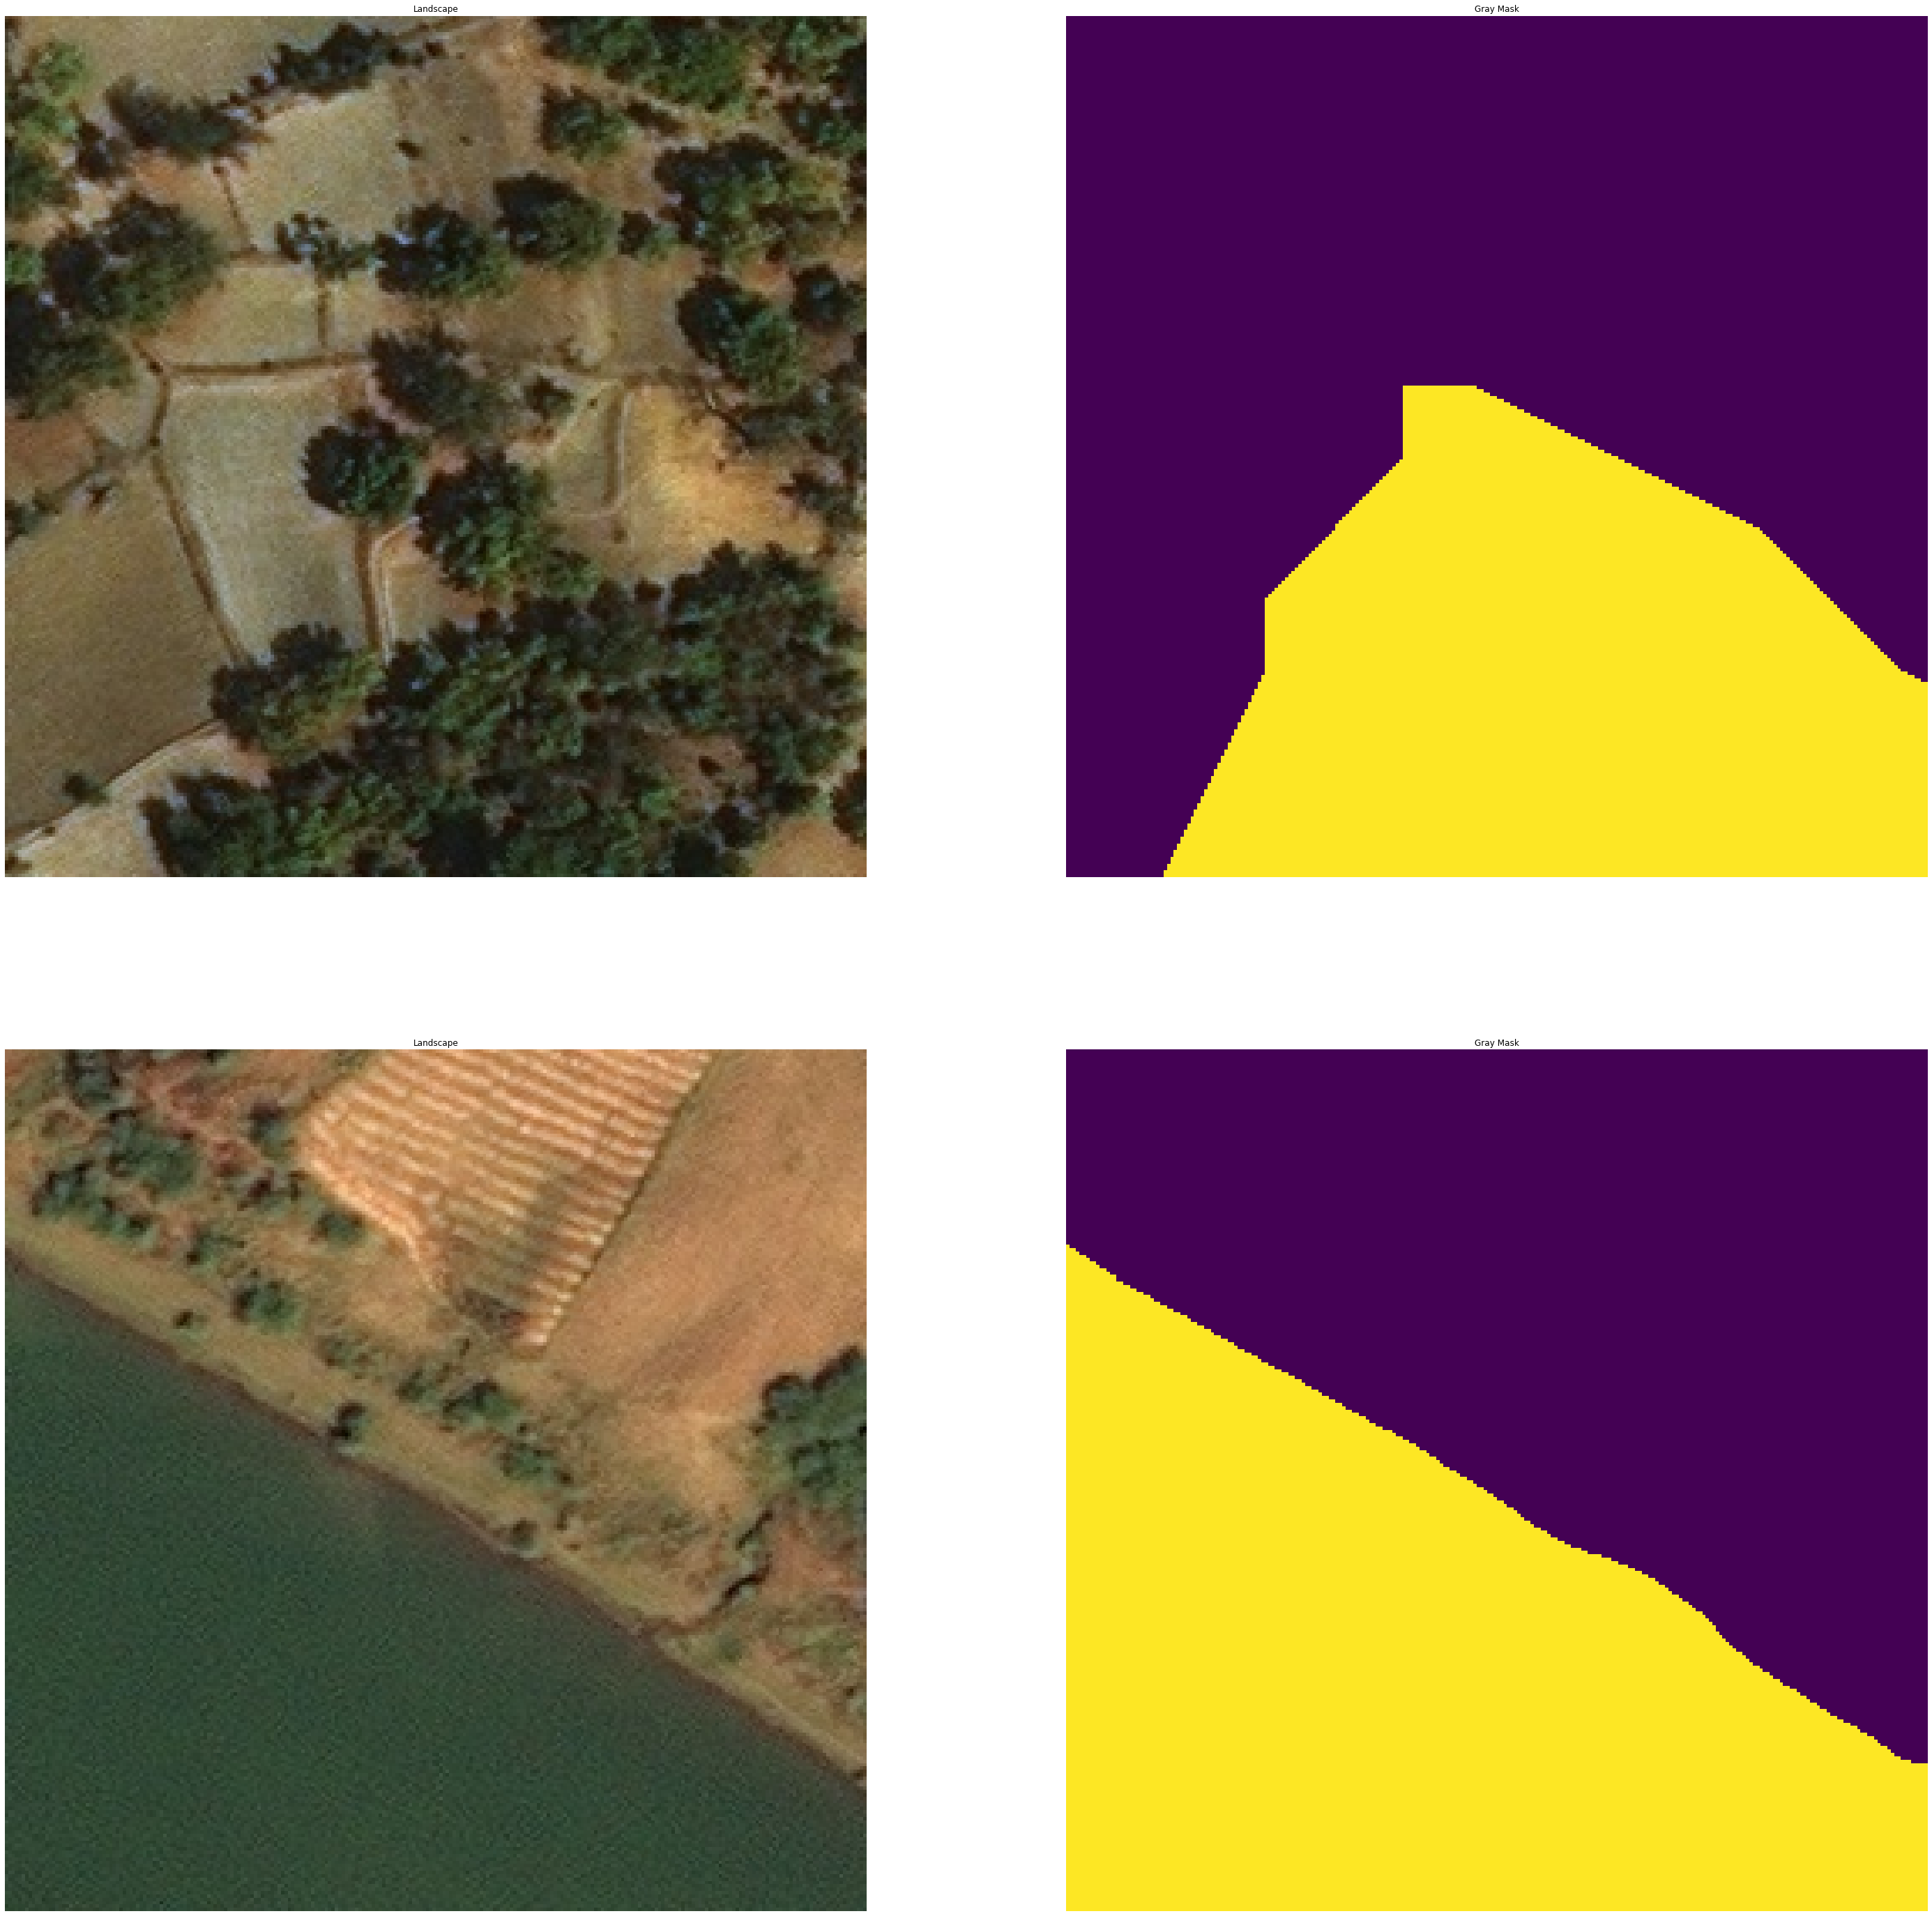

In [24]:
def check_gens(train_gen, valid_gen):
    x, y = next(train_gen)
    i =8
    plt.figure(figsize = (50,50))
    plt.subplot(221)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(222)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread('../input/patched/data/masks256/1.tif')
    plt.imshow(np.argmax((y)[i],axis=2)*64)


    x, y = next(valid_gen)
    plt.subplot(223)
    plt.axis('off')
    plt.title('Landscape')
    plt.imshow(x[i])

    plt.subplot(224)
    plt.axis('off')
    plt.title('Gray Mask')
    mask =  cv2.imread('../input/patched/data/masks256/1.tif')
    plt.imshow(np.argmax((y)[i],axis=2)*64)
check_gens(t,v)

### Callbacks

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

def callback(name):
    checkpoint = ModelCheckpoint("{}.h5".format(name), monitor='val_iou_score', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
    reduce = ReduceLROnPlateau(monitor='val_iou_score',
                                   patience=2, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)

    early = EarlyStopping(monitor="val_iou_score", 
                      mode="min", 
                      patience=2)
    
    tensorboard = TensorBoard(log_dir="logs/{}".format(name))
    
    callbacks = [checkpoint, early, reduce,tensorboard]

### U-net Model

In [26]:

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [27]:
model = unet()
from tensorflow.keras.metrics import MeanIoU
model.compile(optimizer = Adam(lr = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

2022-05-09 22:37:37.307320: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### U-net using segmentation models

In [29]:
def u_net_models(backbones):
    
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), 'accuracy']
    histories = {}
    
    for backbone in backbones:
        callbacks = callback(backbone)
        
        model = sm.Unet(backbone, encoder_weights='imagenet', 
                input_shape=(256,256,3),
                classes=7, activation='softmax')
        model.compile(optimizer = Adam(lr = 0.0001), loss=sm.losses.categorical_focal_jaccard_loss, metrics=metrics)
        
        train_gen,valid_gen = train_valid_gen(7)
        print('Model : {}'.format(backbone))
        history = model.fit_generator(train_gen,
                steps_per_epoch=2692// batch_size,
                epochs=50, validation_data = valid_gen, validation_steps=300//batch_size, callbacks =callbacks)
        model.save('{}.h5'.format(backbone))
        histories[backbone] = history
    return histories

In [30]:
backbones = ['resnet34', 'inceptionv3', 'vgg16']

In [31]:
# histories = u_net_models(backbones)

In [32]:
def predict_image(model, img):
    w,h = img.shape[:2]
    w = w // 256 +1
    h = h // 256 +1
    padding_shape = (w*256,h*256 ,3)
    padded_img= np.zeros(padding_shape)
    mask_shape = (w*256,h*256,7)

    padded_img[0:img.shape[0], 0:img.shape[1], :] = img
    padded_img = padded_img/255
    mask_padded = np.zeros(mask_shape)

    for i in range(0,mask_shape[0], 256):
        for j in range(0, mask_shape[1], 256):
            patch = padded_img[i:i+256,j:j+256,:]
            predicted  = model.predict(np.expand_dims(patch,axis=0))
            mask_padded[i:i+256,j:j+256,:] =predicted 
    return mask_padded[0:img.shape[0], 0:img.shape[1], :]

In [33]:
models_path = ['../input/models/resnet34.h5','../input/models/inceptionv3.h5', '../input/models/vgg16.h5']


In [34]:
def predict(img, paths):
    predicted_masks = []
    for path in models_path:
        model = keras.models.load_model(path,
                                        custom_objects={'focal_loss_plus_jaccard_loss': sm.losses.categorical_focal_jaccard_loss,
                                                        'iou_score':sm.metrics.IOUScore, 
                                                        'threshold': 0.5,
                                                        'f1-score':sm.metrics.FScore})

        predicted_masks.append(predict_image(model, img))
    return predicted_masks

In [35]:
img = cv2.imread('../input/deepglobe-land-cover-classification-dataset/train/10452_sat.jpg')

In [36]:
predicted_masks = predict(img, models_path)

2022-05-09 22:37:47.983732: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


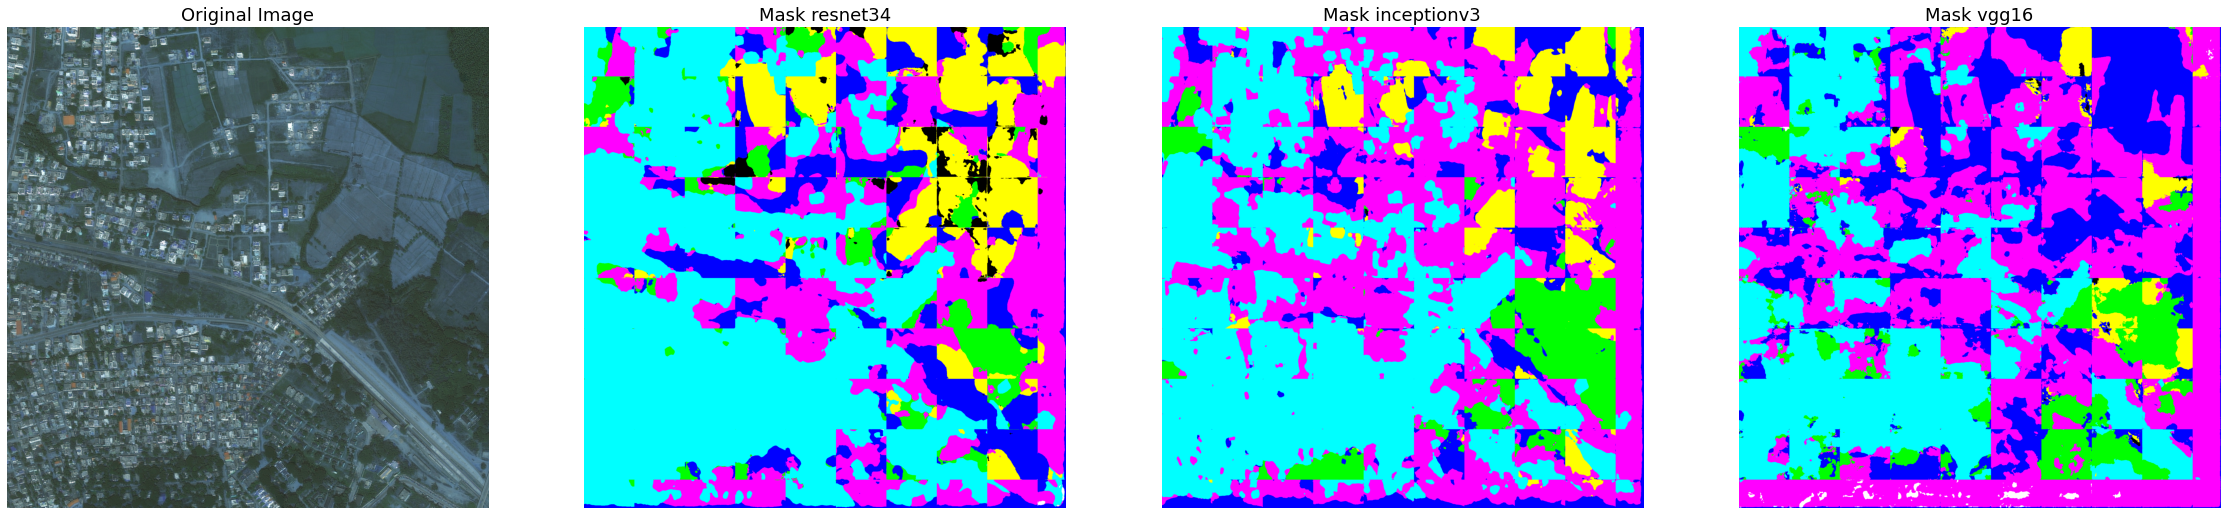

In [37]:
def plot(predicted_masks):
    plt.figure(figsize=(50,50))
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

    plt.subplot(151)
    plt.title('Original Image' ,fontsize=18)
    plt.axis('off')
    plt.imshow(img)

    plt.subplot(152)
    plt.title('Mask {}'.format(backbones[0]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[0]))

    plt.subplot(153)
    plt.title('Mask {}'.format(backbones[1]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[1]))

    plt.subplot(154)
    plt.title('Mask {}'.format(backbones[2]) ,fontsize=18)
    plt.axis('off')
    plt.imshow(onehot_to_rgb(predicted_masks[2]))
    plt.savefig('models_masks.jpeg',dpi = 100)
plot(predicted_masks)

In [38]:
img = cv2.imread('../input/deepglobe-land-cover-classification-dataset/valid/251219_sat.jpg')

In [39]:
predicted_masks = predict(img, models_path)

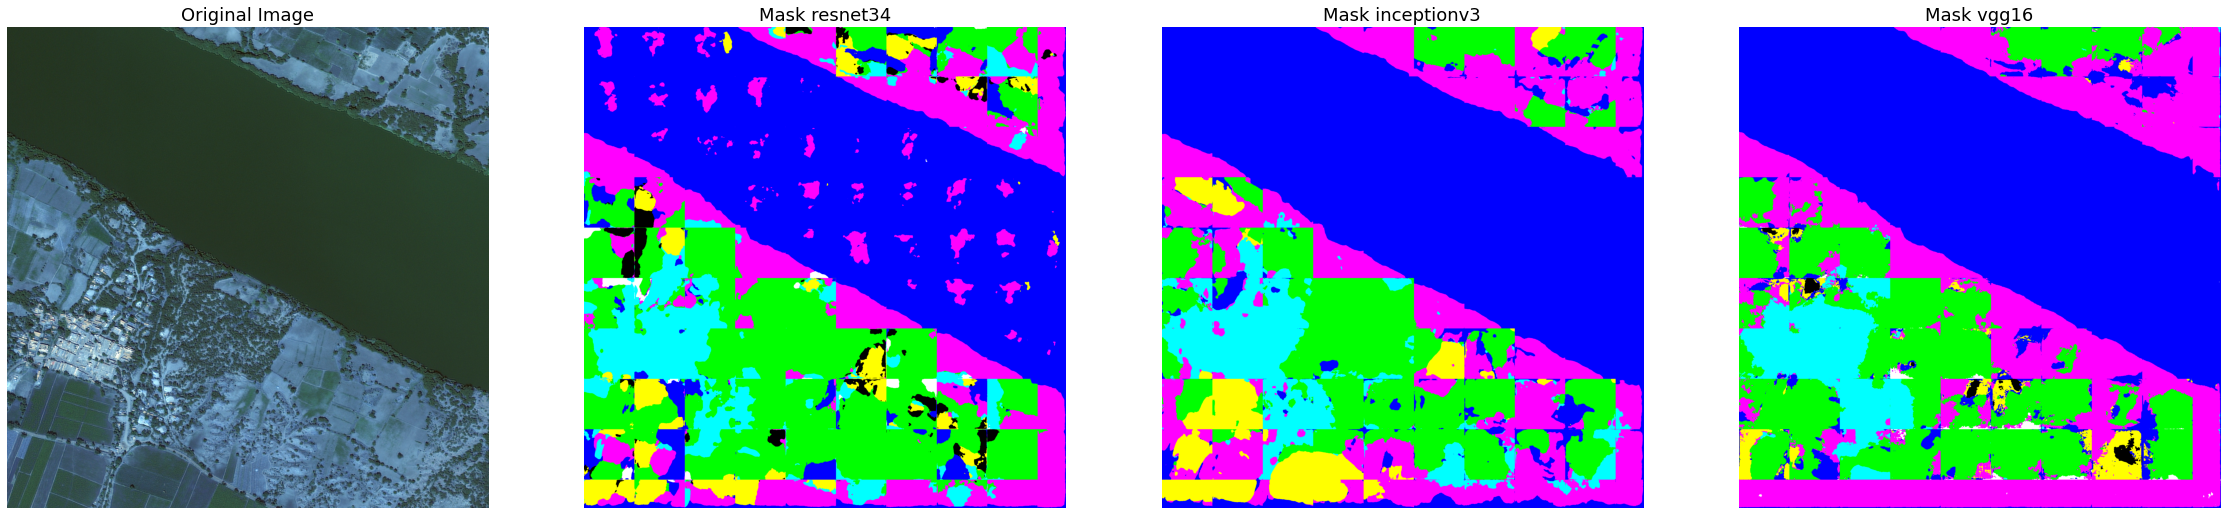

In [40]:
plot(predicted_masks)